In [28]:
from sklearn.datasets import fetch_20newsgroups
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib as mpl
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set()
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [ ]:
# 계층적 클러스터링

In [2]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words = stop_words+list(string.printable)
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\beaus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\beaus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
categories = ['misc.forsale', 'sci.electronics', 'talk.religion.misc']  # 0, 1, 2

In [4]:
news_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42, download_if_missing=True)  

In [5]:
news_data['data'][:5]  # 처음 5개 기사 확인

['From: Steve@Busop.cit.wayne.edu (Steve Teolis)\nSubject: Re: *** TurboGrafx System For SALE ***\nOrganization: Wayne State University\nLines: 38\nDistribution: na\nNNTP-Posting-Host: 141.217.75.24\n\n>TurboGrafx-16 Base Unit (works like new) with:\n>       1 Controller\n>       AC Adapter\n>       Antenna hookup\n>     * Games:\n>         Kieth Courage\n>         Victory Run\n>         Fantasy Zone\n>         Military Madness\n>         Battle Royal\n>         Legendary Axe\n>         Blazing Lasers\n>         Bloody Wolf\n>\n>  --------------------------------------\n>* Will sell games separatley at $25 each\n>  --------------------------------------\n\nYour kidding, $210.00, man o man, you can buy the system new for $49.00 at \nElectronic Boutique and those games are only about $15 - $20.00 brand new.  \nMaybe you should think about that price again if you REALLY need the money.\n\n\n\n\n\n\n                        \n                        \n                        -=-=-=-=-=-=-=-

In [17]:
news_data.target

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [13]:
news_data.target_names

['misc.forsale', 'sci.electronics', 'talk.religion.misc']

In [14]:
news_data_df = pd.DataFrame({'text' : news_data['data'], 'category' : news_data.target})
news_data_df.head()

,text,category
0,From: Steve@Busop.cit.wayne.edu (Steve Teolis)...,0
1,From: jks2x@holmes.acc.Virginia.EDU (Jason K. ...,0
2,From: wayne@uva386.schools.virginia.edu (Tony ...,1
3,From: lihan@ccwf.cc.utexas.edu (Bruce G. Bostw...,1
4,From: myoakam@cis.ohio-state.edu (micah r yoak...,0


In [16]:
news_data_df['category'].value_counts()  # 각 category에 해당하는 기사 개수

1    591
0    585
2    377
Name: category, dtype: int64

In [18]:
news_data_df['cleaned_text'] = news_data_df['text'].apply(\
                                   lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
                                   for word in word_tokenize(re.sub(r'([^\s\w]_)+', ' ', str(x))) if word.lower() not in stop_words])
                               )

In [19]:
# TF-IDF DataFrame 생성
tfidf_model = TfidfVectorizer(max_features=200)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(news_data_df['cleaned_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,00,10,100,12,14,15,16,20,25,30,...,well,wire,wiring,without,word,work,world,would,writes,year
0,0.435585,0.0,0.000000,0.0,0.000000,0.127755,0.136789,0.12753,0.133289,0.0,...,0.0,0.0,0.0,0.0,0.0,0.11318,0.000000,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.249879,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.140439,0.102891,0.099018,0.0
4,0.000000,0.0,0.215013,0.0,0.199323,0.189186,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0


In [20]:
# 거리 행렬 생성 (거리 = 1 - TF-IDF에 대한 코사인 유사도)
dist = 1 - cosine_similarity(tfidf_df)
linkage_matrix = ward(dist)  # 연결 행렬 생성

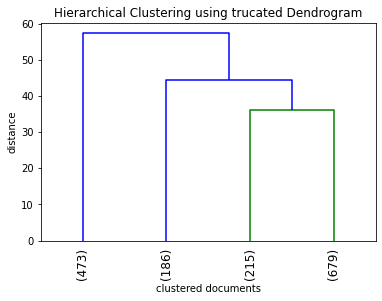

In [22]:
# 마지막 4개 클러스터만 남기기 위해 덴드로그램 자르기
plt.title('Hierarchical Clustering using trucated Dendrogram')
plt.xlabel('clustered documents')
plt.ylabel('distance')

dendrogram(
    linkage_matrix,
    truncate_mode = 'lastp', # 병합한 후 마지막 p개 클러스터만 출력
    p = 4,
    leaf_rotation = 90.,  # leaf label을 회전시킬 각도
    leaf_font_size = 12.
)
plt.show()

In [23]:
# 클러스터링으로 얻은 category label
k=4
clusters = fcluster(linkage_matrix, k, criterion='maxclust')
clusters

array([1, 1, 1, ..., 4, 4, 1], dtype=int32)

In [25]:
# 클러스터링 결과와 실제 category label 비교
news_data_df['obtained_clusters'] = clusters
pd.crosstab(news_data_df['category'].replace({0:'misc.forsale', 1:'sci.electronics', 2:'talk.religion.misc'}), \
            news_data_df['obtained_clusters'].replace({1:'cluster_1', 2: 'cluster_2', 3:'cluster_3', 4:'cluster_4'}))

obtained_clusters,cluster_1,cluster_2,cluster_3,cluster_4
category,,,,
misc.forsale,263,1,191,130
sci.electronics,140,0,23,428
talk.religion.misc,70,185,1,121


In [ ]:
# K-평균 클러스터링

In [29]:
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
lemmatizer = WordNetLemmatizer()

In [30]:
categories = ['misc.forsale', 'sci.electronics', 'talk.religion.misc']

In [32]:
news_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42, download_if_missing=True)

In [33]:
news_data_df['cleaned_text'] = news_data_df['text'].apply(\
                                lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
                                for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if word.lower() not in stop_words]))

In [34]:
# TF-IDF DataFrame 생성
tfidf_model = TfidfVectorizer(max_features=200)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(news_data_df['cleaned_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,00,10,100,12,14,15,16,20,25,30,...,well,wire,wiring,without,word,work,world,would,writes,year
0,0.435655,0.0,0.000000,0.0,0.000000,0.127775,0.136811,0.127551,0.133311,0.0,...,0.0,0.0,0.0,0.0,0.0,0.113042,0.000000,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.294937,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.142267,0.106317,0.100306,0.0
4,0.000000,0.0,0.207003,0.0,0.191897,0.182138,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [36]:
# TF-IDF로부터 4개의 클러스터를 만듦
kmeans = KMeans(n_clusters=4)
kmeans.fit(tfidf_df)
y_kmeans = kmeans.predict(tfidf_df)
news_data_df['obtained_clusters'] = y_kmeans

In [38]:
# 클러스터 결과와 실제 category label 비교
pd.crosstab(news_data_df['category'].replace({0:'misc.forsale', 1:'sci.electronics', 2:'talk.religion.misc'}), \
            news_data_df['obtained_clusters'].replace({0:'cluster_1', 1: 'cluster_2', 2:'cluster_3', 3:'cluster_4'}))

obtained_clusters,cluster_1,cluster_2,cluster_3,cluster_4
category,,,,
misc.forsale,135,100,1,349
sci.electronics,159,420,0,12
talk.religion.misc,77,72,228,0


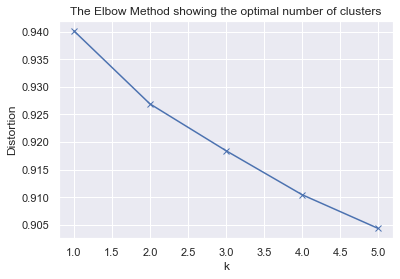

In [39]:
# 최적의 k값(클러스터 개수)을 얻기 위해 k를 1~6으로 변경하면서 K-평균 알고리즘 실행
# 가장 기울기가 가파른 값이 k가 됨 (이 경우 2)
distortions = []
K = range(1,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_df)
    distortions.append(sum(np.min(cdist(tfidf_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tfidf_df.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()